# US SSA Birth Data

We're going to explore some data on births in the US from the US Social Security Administration. The data we'll be using was curated by [FiveThirtyEight](https://github.com/fivethirtyeight/data/tree/master/births).

The data is already in this repository in the `data` directory, but you could also download it from [here](https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_2000-2014_SSA.csv).

```bash
mkdir -p ../data
wget -qO ../data/US_births_2000-2014_SSA.csv https://raw.githubusercontent.com/fivethirtyeight/data/master/births/US_births_2000-2014_SSA.csv
```

To get started we'll have to figure out how to read the data contained in the comma separated value (CSV) file.

## Code Editor 

There a number of different ways to interact with the code in this class. If you choose to use the Jupyter Hub provided by OSU through Canvas, then you will be using Jupyter notebooks to do your coding. Most of the course is written as Jupyter notebooks, so this is a great native choice. 

I prefer to use [VSCode](https://code.visualstudio.com/download) on my laptop. Jupyter notebooks run natively, with the correct extensions, inside of `VSCode` and you can additionally setup the work environment as a Docker image within VSCode. (More on that later!)

You are, of course, welcome to use whatever you'd like, but I can not guarantee to be able to help you debug anything but the two options listed here.

## Environments

### Option 1: `devcontainer` 


### Option 2: MicroMamba (like anaconda/conda/miniconda) 
I highly encourage you to use [miniconda](https://docs.conda.io/en/latest/miniconda.html) to manage your python environment (which plays nicely with [VSCode](https://code.visualstudio.com/download)).  Follow the instructions to install miniconda, which will set you up with the `conda` command line tool for managing your environments.

(You can also use [micromamba](https://mamba.readthedocs.io/en/latest/installation/micromamba-installation.html), which is a faster, next generation version of the `conda` software.)

You can use `requirements.txt` in this repository to set up an environment with the packages we need.  To do so, open a terminal window, navigate to the base directory of the repository, and run

```bash
conda create -n scicomp python=3.10 pip
```

This creates an environment called `scicomp` running python version 3.10, with `pip` installed.  Now activate that environment and install the required packages within it:

```bash
conda activate scicomp
pip install -r requirements.txt
```

## I/O with `pandas`

We'll be using `pandas` to read the CSV file and manage data.  I'm going to assume you're using a `conda` environment with `pandas`, `numpy`, `matplotlib`, and `seaborn` installed.  If you're using a different environment, you may have to install some things (e.g., using `pip`).

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('../data/US_births_2000-2014_SSA.csv')
df
# Note that you can change the file path as needed to access the file. 

version https://git-lfs.github.com/spec/v1
0  oid sha256:67ed396cecc999664a737ee75f287cf3472...
1                                         size 96748

The `read_csv()` function automatically parses the column names and assigns proper data types to the columns, returning a `DataFrame` object.  Please read [the docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to learn all the gory details about `DataFrames`.

## Plotting

`matplotlib` is going to be our go-to plotting library.  We'll also make use of some domain-specific plotting libraries like `seaborn`, `arviz`, etc. throughout the term, many of which are built on top of `matplotlib`.

In [4]:
import matplotlib.pyplot as plt

First we'll make a simple histogram.

In [5]:
plt.hist(df['births'])
plt.xlabel('# of births each day')
plt.ylabel('counts');

KeyError: 'births'

We will also be using `numpy` *extensively* for efficient number-crunching.

In [7]:
import numpy as np

In [8]:
np.mean(df['births'])

11350.068260631502

Now let's make a scatter plot.

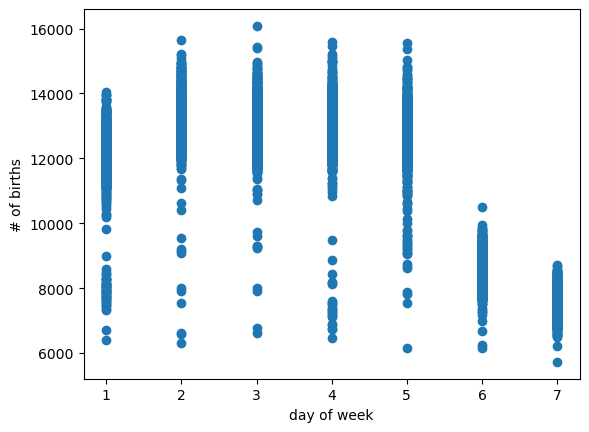

In [9]:
plt.scatter(df['day_of_week'], df['births'])
plt.xlabel('day of week')
plt.ylabel('# of births');

There's a lot of scatter here, so let's use a boolean array to select only the data pertaining to June.

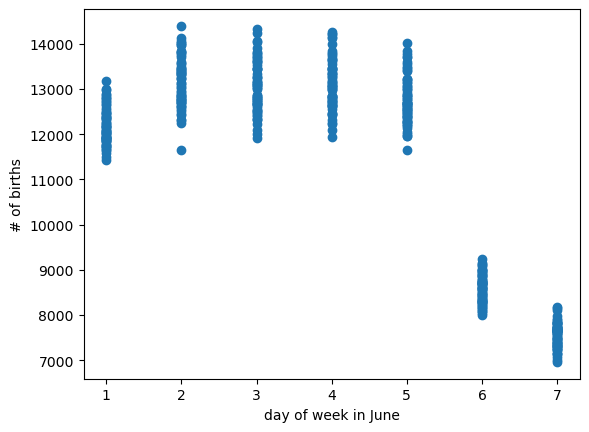

In [10]:
month_sel = df['month'] == 6
plt.scatter(df['day_of_week'][month_sel], df['births'][month_sel])
plt.xlabel('day of week in June')
plt.ylabel('# of births');

Scatter plots aren't the best way to look at discrete data.  A better tool is a violin plot, which plots a kernel density estimate (basically a smoothed histogram) of the distribution of points within each discrete value.  `seaborn` has a nice implementation of such a plotting routine.

In [12]:
import seaborn as sns

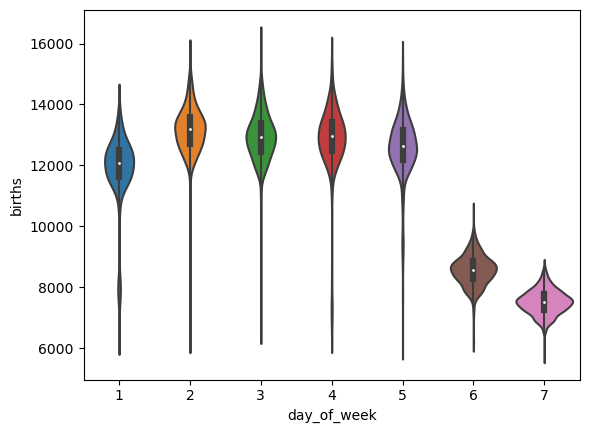

In [14]:
sns.violinplot(x='day_of_week', y='births', data=df);

Now let's use some more advanced features of `pandas`.  First we'll group the data entries by year and compute the total number of births each year.

In [15]:
year_grp = df.groupby('year')
year_grp.sum()

month  date_of_month  day_of_week   births
year                                            
2000   2384           5767         1469  4149598
2001   2382           5738         1457  4110963
2002   2382           5738         1458  4099313
2003   2382           5738         1459  4163060
2004   2384           5767         1465  4186863
2005   2382           5738         1462  4211941
2006   2382           5738         1463  4335154
2007   2382           5738         1457  4380784
2008   2384           5767         1461  4310737
2009   2382           5738         1460  4190991
2010   2382           5738         1461  4055975
2011   2382           5738         1462  4006908
2012   2384           5767         1464  4000868
2013   2382           5738         1458  3973337
2014   2382           5738         1459  4010532

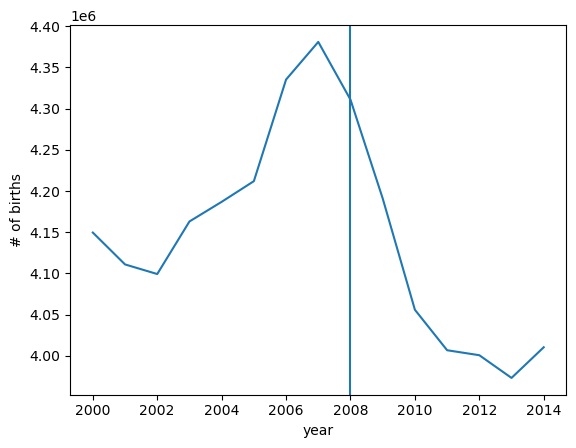

In [31]:
births_by_year = year_grp.sum()

plt.plot(births_by_year.index, births_by_year.births)
plt.ylabel('# of births')
plt.xlabel('year')
plt.axvline(2008)

Now by day of the month.

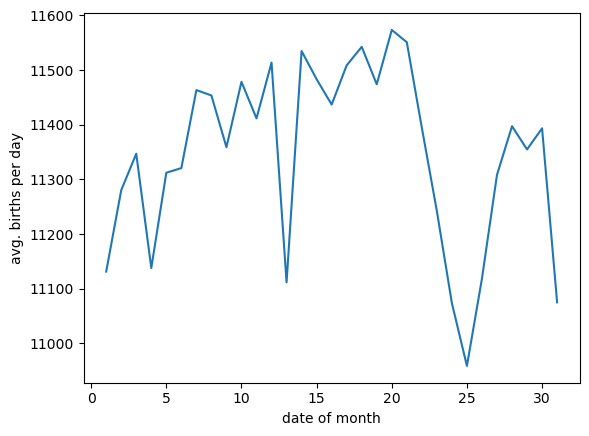

In [17]:
grp = df.groupby('date_of_month')
birth_by_date = grp.mean()

plt.plot(birth_by_date.index, birth_by_date.births)
plt.xlabel('date of month')
plt.ylabel('avg. births per day');

Do people want to make sure they don't miss presents?

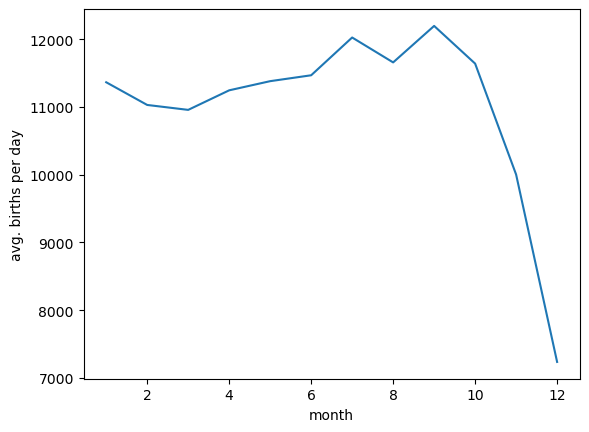

In [18]:
christmas_date_sel = (df['date_of_month'] == 24) | (df['date_of_month'] == 25)

christmas_date_grp = df[christmas_date_sel].groupby('month')
christmas_date_birth_by_month = christmas_date_grp.mean()

plt.plot(christmas_date_birth_by_month.index, christmas_date_birth_by_month.births)
plt.xlabel('month')
plt.ylabel('avg. births per day');

It looks like they don't want to miss out on turkey either...  Let's try ignoring holidays.

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime

In [20]:
dates = np.array([datetime(y, m, d) for (y, m, d) in df[['year', 'month', 'date_of_month']].values])
print(dates)

[datetime.datetime(2000, 1, 1, 0, 0) datetime.datetime(2000, 1, 2, 0, 0)
 datetime.datetime(2000, 1, 3, 0, 0) ...
 datetime.datetime(2014, 12, 29, 0, 0)
 datetime.datetime(2014, 12, 30, 0, 0)
 datetime.datetime(2014, 12, 31, 0, 0)]


In [21]:
fed_cal = USFederalHolidayCalendar()
holidays = fed_cal.holidays(start=dates.min(), end=dates.max()).to_pydatetime()
print(datetime(2000, 12, 25) in holidays)

True


In [22]:
holiday_sel = np.array([date in holidays for date in dates])

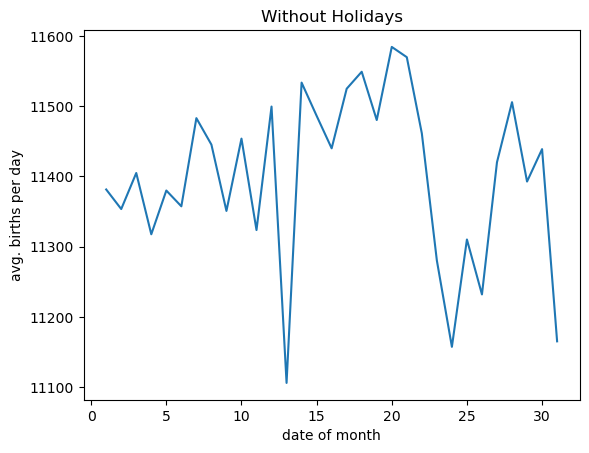

In [23]:
grp = df[~holiday_sel].groupby('date_of_month')
birth_by_date = grp.mean()

plt.plot(birth_by_date.index, birth_by_date.births)
plt.xlabel('date of month')
plt.ylabel('avg. births per day')
plt.title('Without Holidays');

Better, but still not great.  Let's try adding a few more holidays.

In [24]:
print(datetime(2000, 12, 24) in holidays)
print(datetime(2000, 12, 31) in holidays)

False
False


In [25]:
from pandas.tseries.holiday import get_calendar, Holiday, HolidayCalendarFactory, FR

In [26]:
xmas_eve = Holiday('Christmas Eve', month=12, day=24)
new_years_eve = Holiday('New Year\'s Eve', month=12, day=31)
black_friday = Holiday("Black Friday", month=11, day=1, offset=pd.DateOffset(weekday=FR(4)))

cal = HolidayCalendarFactory('ExpandedHolidayCal', fed_cal, [black_friday, xmas_eve, new_years_eve])()
holidays = cal.holidays(start=dates.min(), end=dates.max()).to_pydatetime()
holiday_sel = np.array([date in holidays for date in dates])

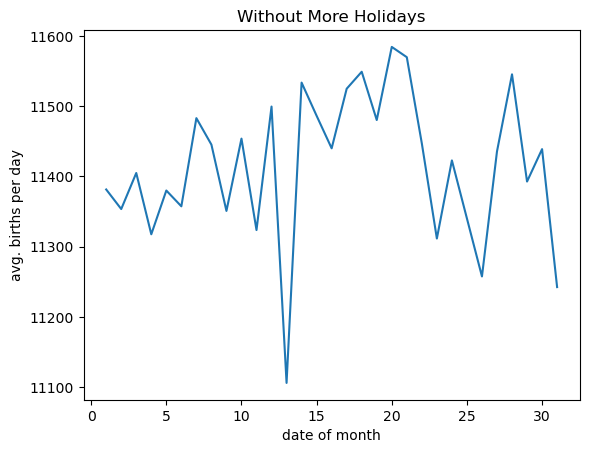

In [27]:
grp = df[~holiday_sel].groupby('date_of_month')
birth_by_date = grp.mean()

plt.plot(birth_by_date.index, birth_by_date.births)
plt.xlabel('date of month')
plt.ylabel('avg. births per day')
plt.title('Without More Holidays');

It looks like people may be superstitious...

**NOTE**: From now on we'll leave out holidays.

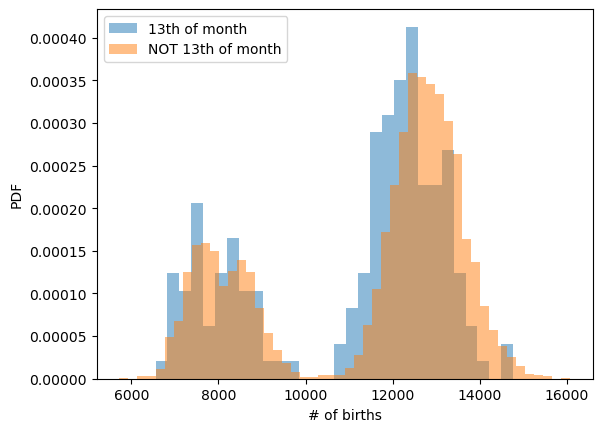

In [28]:
thirteenth_sel = df['date_of_month'] == 13

plt.hist(df[thirteenth_sel & ~holiday_sel]['births'], density=True, alpha=0.5, bins=30, label='13th of month')
plt.hist(df[~thirteenth_sel & ~holiday_sel]['births'], density=True, alpha=0.5, bins=50, label='NOT 13th of month')
plt.xlabel('# of births')
plt.ylabel('PDF')
plt.legend();

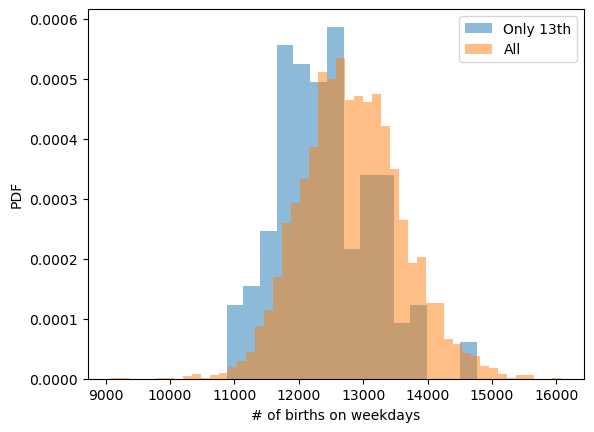

In [29]:
weekday_sel = df['day_of_week'] < 6
weekday_thirteenth_sel = (df['date_of_month'] == 13) & weekday_sel

plt.hist(df[weekday_thirteenth_sel & ~holiday_sel]['births'], density=True, alpha=0.5, bins=15, label='Only 13th')
plt.hist(df[weekday_sel & ~holiday_sel]['births'], density=True, alpha=0.5, bins=50, label='All')
plt.xlabel('# of births on weekdays')
plt.ylabel('PDF')
plt.legend();

Is Friday the 13th avoided more than the 13th on any other weekday?

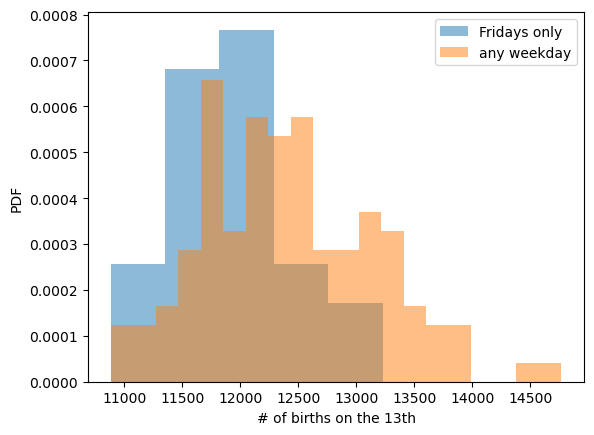

In [30]:
fri_thirteenth_sel = (df['date_of_month'] == 13) & (df['day_of_week'] == 5)

plt.hist(df[fri_thirteenth_sel & ~holiday_sel]['births'], density=True, alpha=0.5, bins=5, label='Fridays only')
plt.hist(df[weekday_thirteenth_sel & ~holiday_sel]['births'], density=True, alpha=0.5, bins=20, label='any weekday')
plt.xlabel('# of births on the 13th')
plt.ylabel('PDF')
plt.legend();